In [1]:
import numpy as np
import time
from numpy import *
from scipy import io

import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sys
sys.path.append("../")

from spline import splineBasis
from ado import * 

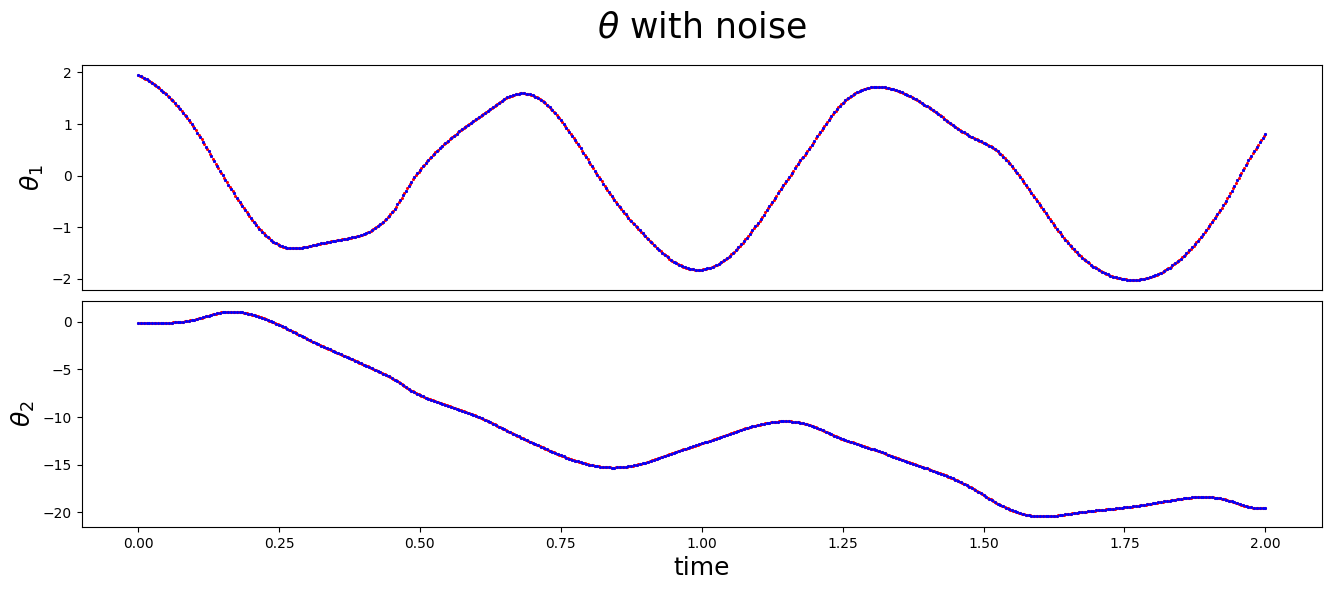

In [2]:
sim_measurement = io.loadmat('../systems/Double pendulum/data_ode113.mat')['x'][:801, :]

t_m_all = np.linspace(0, 2, 801)

x_sample = sim_measurement[:, :2]
w_sample = sim_measurement[:, 2:4]

x_sample_shift = x_sample.copy()
    
for i in range(x_sample_shift.shape[0]):
    if abs(x_sample_shift[i, 0]) >= np.pi:
        x_sample_shift[i:, 0] -= 2 * np.pi * np.sign(x_sample_shift[i, 0])
    if abs(x_sample_shift[i, 1]) >= np.pi:
        x_sample_shift[i:, 1] -= 2 * np.pi * np.sign(x_sample_shift[i, 1])


n_ratio = 0.00 # noise ratio
sub_idx = [int(x) for x in np.linspace(0, 800, 401)] # sub_ratio = 0.5
t_m = t_m_all[sub_idx]

coordx1_true = 9.1 * np.sin(x_sample[:, 0])
coordy1_true = -9.1 * np.cos(x_sample[:, 0])
coordx2_true = coordx1_true + 7 * np.sin(x_sample[:, 1])
coordy2_true = coordy1_true - 7 * np.cos(x_sample[:, 1])

np.random.seed(0)

coordx1_n = np.random.normal(0,1,len(t_m_all))
coordx1_n = coordx1_n / np.std(coordx1_n)
coordx1_noise = (coordx1_true + n_ratio * np.std(coordx1_true) * coordx1_n)[sub_idx]

coordy1_n = np.random.normal(0,1,len(t_m_all))
coordy1_n = coordy1_n / np.std(coordy1_n)
coordy1_noise = (coordy1_true + n_ratio * np.std(coordy1_true) * coordy1_n)[sub_idx]

coordx2_n = np.random.normal(0,1,len(t_m_all))
coordx2_n = coordx2_n / np.std(coordx2_n)
coordx2_noise = (coordx2_true + n_ratio * np.std(coordx2_true) * coordx2_n)[sub_idx]

coordy2_n = np.random.normal(0,1,len(t_m_all))
coordy2_n = coordy2_n / np.std(coordy2_n)
coordy2_noise = (coordy2_true + n_ratio * np.std(coordy2_true) * coordy2_n)[sub_idx]


x_noise_shift = np.zeros([len(t_m), 2])

for i in range(len(t_m)):
    x_noise_shift[i, 0] = math.atan2(coordy1_noise[i], coordx1_noise[i]) + 0.5*np.pi
    x_noise_shift[i, 1] = math.atan2(coordy2_noise[i] - coordy1_noise[i], 
                               coordx2_noise[i] - coordx1_noise[i]) + 0.5*np.pi
for i in range(x_noise_shift.shape[0]):
    for j in range(x_noise_shift.shape[1]):
        if x_noise_shift[i, j] > np.pi:
            x_noise_shift[i, j] = x_noise_shift[i, j] - 2*np.pi
            
x_noise = x_noise_shift.copy()
    
for i in range(1, x_noise_shift.shape[0]):
    if abs(x_noise_shift[i, 0] - x_noise_shift[i-1, 0]) >= np.pi:
        x_noise[i:, 0] = x_noise[i:, 0] + 2 * np.pi * np.sign(x_noise_shift[i-1, 0] - x_noise_shift[i, 0])
    if abs(x_noise_shift[i, 1] - x_noise_shift[i-1, 1]) >= np.pi:
        x_noise[i:, 1] = x_noise[i:, 1] + 2 * np.pi * np.sign(x_noise_shift[i-1, 1] - x_noise_shift[i, 1])

        
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(211)
ax.set_title('$\\theta$ with noise', fontsize=25, pad=20)
ax.scatter(t_m_all, x_sample[:, 0], c='r', s=1.5)
ax.scatter(t_m, x_noise[:, 0], c='b', s=1.5)
ax.axes.xaxis.set_visible(False)
ax.set_ylabel('$\\theta_1$', fontsize=18)

ax = fig.add_subplot(212)
ax.scatter(t_m_all, x_sample[:, 1], c='r', s=1.5)
ax.scatter(t_m, x_noise[:, 1], c='b', s=1.5)
ax.set_ylabel('$\\theta_2$', fontsize=18)
ax.set_xlabel('time', fontsize=18)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [3]:
end_t = 2
num_control = 100*end_t+1
num_c = 1000*end_t+1

t = np.linspace(0, end_t, num_control)
knots = np.array([0,0,0] + list(t) + [end_t,end_t,end_t])

t_c = np.array(sorted(list(t_m) + list(np.random.rand(num_c-len(t_m))*end_t)))

basis = splineBasis(knots, t_m, t_c)
basis_m, basis_dt_m = basis.get_measurement()
basis_c, basis_dt_c = basis.get_collocation()

In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
num_control = basis_m.shape[1]

# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_dt = torch.Tensor(basis_dt_m).to(device)

# define control points (one column for each variable)
P_theta = torch.autograd.Variable(torch.rand(num_control, 2).to(device), requires_grad=True)

# convert the measurement data into tensor 
mea_theta = torch.Tensor(x_noise).to(device)


def loss_pre(P, mea):
    return (torch.norm(torch.matmul(N, P) - mea, p=2) ** 2) / t_m_len


# define learning rate and optimizer 
learning_rate = 0.05
optimizer = torch.optim.Adam([P_theta], lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

start_time = time.time()

for t in range(20000):

    optimizer.zero_grad()
    
    loss = loss_pre(P_theta, mea_theta)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 19999:
        print("20,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        
x_dot = np.matmul(basis_dt_m, P_theta.cpu().detach().numpy())
mea_omega = torch.Tensor(x_dot).to(device)
P_omega = torch.autograd.Variable(torch.rand(num_control, 2).to(device), requires_grad=True)

# define learning rate and optimizer 
learning_rate = 0.05
optimizer = torch.optim.Adam([P_omega], lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

start_time = time.time()

for t in range(20000):

    optimizer.zero_grad()
    
    loss = loss_pre(P_omega, mea_omega)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 19999:
        print("20,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

Using device: cuda

epoch : 0 loss : 195.09153747558594 lr : 0.05
epoch : 5000 loss : 0.9583058953285217 lr : 5.0000000000000016e-05
epoch : 10000 loss : 0.9583058953285217 lr : 1e-05
Early stopping!
epoch : 12257 loss : 0.9583056569099426 lr : 1e-05
--- 10.918042421340942 seconds ---
epoch : 0 loss : 547.7920532226562 lr : 0.05
epoch : 5000 loss : 0.14729668200016022 lr : 0.05
epoch : 10000 loss : 0.14695721864700317 lr : 5.0000000000000016e-05
epoch : 15000 loss : 0.14695721864700317 lr : 1e-05
Early stopping!
epoch : 16260 loss : 0.14695720374584198 lr : 1e-05
--- 12.473294019699097 seconds ---


In [5]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
t_c_len = basis_c.shape[0]
num_control = basis_m.shape[1]

# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_c = torch.Tensor(basis_c).to(device)
N_dt = torch.Tensor(basis_dt_c).to(device)
# N_dt = torch.Tensor(basis_dt_m).to(device)

# convert the measurement data into tensor 
x_sample = x_noise
measurement = torch.Tensor(x_sample).to(device)

cx1_true = torch.Tensor(coordx1_noise).to(device)
cy1_true = torch.Tensor(coordy1_noise).to(device)
cx2_true = torch.Tensor(coordx2_noise).to(device)
cy2_true = torch.Tensor(coordy2_noise).to(device)


self_library = ['dw1*cos(x1-x2)', 'dw2*cos(x1-x2)', 'w1**2*sin(x1-x2)', 'w2**2*sin(x1-x2)', 
                'w1**2*sin(x1)', 'w2**2*sin(x1)', 'w1**2*sin(x2)', 'w2**2*sin(x2)',
                'w1*sin(x1-x2)', 'w2*sin(x1-x2)', 'w1*sin(x1)', 'w2*sin(x1)', 'w1*sin(x2)', 'w2*sin(x2)',
                'sin(x1)', 'sin(x2)', 'sin(x1-x2)']
                      
function_w1 = ''
function_w2 = ''


num_term = len(self_library)

for i in range(0, num_term):
    term = self_library[i]
    function_w1 += ('+cx'+str(i)+'*'+term)
    function_w2 += ('+cy'+str(i)+'*'+term)
function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]

Using device: cuda



In [6]:
# define control points (one column for each variable)
# P = torch.autograd.Variable(torch.rand(num_control, 4).to(device), requires_grad=True)
P_init = torch.cat((P_theta, P_omega), 1).cpu().detach()

## define variables Gamma and auxiliary variables Y and Z
P = torch.autograd.Variable(P_init.to(device), requires_grad=True)



################################################
########## use a full term library #############
################################################

for i in range(num_term): globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
for i in range(num_term): globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
    

coef_lst = [globals()['cx'+str(i)] for i in range(num_term)] + \
           [globals()['cy'+str(i)] for i in range(num_term)]

################################################
################################################


loss1_his = []
loss2_his = []
loss3_his = []


# physics loss (denominator values known, calculate in the measurement domain)
def loss_phy(P):
    x1 = torch.matmul(N_c, P[:, 0])
    x2 = torch.matmul(N_c, P[:, 1])
    w1 = torch.matmul(N_c, P[:, 2])
    w2 = torch.matmul(N_c, P[:, 3])
    dw1 = torch.matmul(N_dt, P[:, 2])
    dw2 = torch.matmul(N_dt, P[:, 3])
    
    return (1000 * torch.norm(torch.matmul(N_dt, P[:, 0]) - w1, p=2) ** 2 +
            1000 * torch.norm(torch.matmul(N_dt, P[:, 1]) - w2, p=2) ** 2 +
            torch.norm(torch.matmul(N_dt, P[:, 2]) - eval(function_w1), p=2) ** 2 + 
            torch.norm(torch.matmul(N_dt, P[:, 3]) - eval(function_w2), p=2) ** 2) / t_c_len


def loss_coord(P):
    x1 = torch.matmul(N, P[:, 0])
    x2 = torch.matmul(N, P[:, 1])
    cx1_pred = 0 + 9.1*torch.sin(x1)
    cy1_pred = 0 - 9.1*torch.cos(x1)
    cx2_pred = cx1_pred + 7*torch.sin(x2)
    cy2_pred = cy1_pred - 7*torch.cos(x2)
    return (torch.norm(cx1_pred - cx1_true, p=2) ** 2 + torch.norm(cy1_pred - cy1_true, p=2) ** 2 +
            torch.norm(cx2_pred - cx2_true, p=2) ** 2 + torch.norm(cy2_pred - cy2_true, p=2) ** 2) / t_m_len
            

# data loss + physics loss
def loss_total(P):
    loss_p = loss_phy(P)
    loss_c = loss_coord(P)
    loss_d = (torch.norm(torch.matmul(N, P[:,0]) - measurement[:,0], p=2) ** 2 + 
              torch.norm(torch.matmul(N, P[:,1]) - measurement[:,1], p=2) ** 2) / t_m_len
    
    loss1_his.append(float(loss_d.cpu().detach().numpy()))
    loss2_his.append(float(loss_c.cpu().detach().numpy()))
    loss3_his.append(float(loss_p.cpu().detach().numpy()))
    
    return loss_d + loss_c + 0.001*loss_p


# define learning rate and optimizer 
learning_rate = 0.01
optimizer = torch.optim.Adamax([P] + coef_lst, lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0


start_time = time.time()

for t in range(200000):
     

    optimizer.zero_grad()
    
    loss = loss_total(P)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 199999:
        print("200,000 epochs completed!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0 loss : 1304.5574951171875 lr : 0.01
epoch : 5000 loss : 2.31768798828125 lr : 0.01
epoch : 10000 loss : 1.9391393661499023 lr : 0.01
epoch : 15000 loss : 1.791190505027771 lr : 0.01
epoch : 20000 loss : 1.5523202419281006 lr : 0.01
epoch : 25000 loss : 1.1882470846176147 lr : 0.01
epoch : 30000 loss : 1.171267032623291 lr : 0.01
epoch : 35000 loss : 1.1612319946289062 lr : 0.01
epoch : 40000 loss : 1.1555196046829224 lr : 0.01
epoch : 45000 loss : 1.1521015167236328 lr : 0.01
epoch : 50000 loss : 1.1503130197525024 lr : 0.01
epoch : 55000 loss : 1.1489348411560059 lr : 0.01
epoch : 59998 loss : 1.1482906341552734 lr : 1e-05
Early stopping!
--- 1042.86869597435 seconds ---


In [7]:
loss_pretuning = loss.item()

# prepare a copy of pre-tuned control points values 
P_pre = P.cpu().detach().numpy().copy()

# convert the pre-tuned equation parameters in matrix form 
lambda_raw = np.zeros([num_term, 2])

function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    lambda_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
    lambda_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
    function_dw1 += (' + '+str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 4))+'*'+term)
    function_dw2 += (' + '+str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 4))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw2_pre-tune =', function_dw1)
print('dw1_pre-tune =', function_dw2)

dw2_pre-tune = 0.0117*dw1*cos(x1-x2) - 0.1715*dw2*cos(x1-x2) + 0.024*w1**2*sin(x1-x2) - 0.1643*w2**2*sin(x1-x2) - 0.0124*w1**2*sin(x1) - 0.0052*w2**2*sin(x1) + 0.0069*w1**2*sin(x2) + 0.0051*w2**2*sin(x2) - 0.0147*w1*sin(x1-x2) + 0.0348*w2*sin(x1-x2) + 0.0287*w1*sin(x1) - 0.0365*w2*sin(x1) - 0.0272*w1*sin(x2) + 0.0529*w2*sin(x2) - 105.246*sin(x1) - 0.0978*sin(x2) - 3.4615*sin(x1-x2)
dw1_pre-tune = -1.0989*dw1*cos(x1-x2) + 0.0039*dw2*cos(x1-x2) + 1.5315*w1**2*sin(x1-x2) + 0.0304*w2**2*sin(x1-x2) - 0.0667*w1**2*sin(x1) - 0.0038*w2**2*sin(x1) + 0.0439*w1**2*sin(x2) - 0.0074*w2**2*sin(x2) + 0.0371*w1*sin(x1-x2) + 0.0197*w2*sin(x1-x2) + 0.012*w1*sin(x1) + 0.0558*w2*sin(x1) + 0.0894*w1*sin(x2) - 0.0576*w2*sin(x2) + 5.0835*sin(x1) - 114.2208*sin(x2) - 21.8454*sin(x1-x2)


In [8]:
loss_HY = []
loss_HY_min = 1000000

terms_HY = [num_term*2]

A_raw = lambda_raw.copy()
A_raw_HY = A_raw.copy()

P_HY_np = P_pre.copy()
P_HY = torch.autograd.Variable(torch.Tensor(P_HY_np).to(device), requires_grad=True)

diminish_coef = True
num_terms  = np.count_nonzero(A_raw)

d_tol = 0.01
lam = 1e-6 # ridge regularizer 
eta = 0.01 # l-0 penalty ratio
        
tol_best = [0, 0]
        
start_time = time.time()

itr = 0

while diminish_coef or itr < 5:

    print('itr:' + str(itr+1))
    
    #############################################################################
    ################  ADO part1: refined training of Parameters #################  
    
    print('Training parameters (STRidge):')
    
    x1 = torch.matmul(N_c, P_HY[:, 0]).cpu().detach().numpy()
    x2 = torch.matmul(N_c, P_HY[:, 1]).cpu().detach().numpy()
    w1 = torch.matmul(N_c, P_HY[:, 2]).cpu().detach().numpy()
    w2 = torch.matmul(N_c, P_HY[:, 3]).cpu().detach().numpy()
    dw1 = torch.matmul(N_dt, P_HY[:, 2]).cpu().detach().numpy()
    dw2 = torch.matmul(N_dt, P_HY[:, 3]).cpu().detach().numpy()

    phi = np.zeros([t_c_len, num_term])
    for i in range(num_term):
        phi[:, i] = eval(self_library[i])

    A_raw[:, 0], tol_best[0] = TrainSTRidge(phi, dw1, lam, eta, d_tol, maxit = 500)
    A_raw[:, 1], tol_best[1] = TrainSTRidge(phi, dw2, lam, eta, d_tol, maxit = 500)
    
    print('best tolerance threshold is', tol_best)
    print('prune number of terms to', np.count_nonzero(A_raw))
    print()
    
    function_w1 = function_w2 = ''
    sparse_c_lst = []

    for i in range(0, num_term):
        term = self_library[i]
        if A_raw[i, 0] != 0: 
            function_w1 += ('+cx'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cx'+str(i)])
        if A_raw[i, 1] != 0: 
            function_w2 += ('+cy'+str(i)+'*'+term) 
            sparse_c_lst.append(globals()['cy'+str(i)])
            
    function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
    function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
    
    
    #################################################################
    ################  ADO part2: Brute Force traing #################
    
    print('Spline Training:')
        
    learning_rate = 0.01
    optimizer = torch.optim.Adamax([P_HY] + sparse_c_lst, lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.00001)

    min_loss = 10000
    epochs_no_improve = 0

    loss_his = []

    for t in range(20000):
        optimizer.zero_grad()

        loss = loss_total(P_HY)
        loss.backward()

        scheduler.step(loss)
        loss_his.append(loss.item())
        
        optimizer.step()

        if loss.item() >= min_loss:
            epochs_no_improve += 1
        else:
            min_loss = loss.item()
            epochs_no_improve = 0

        if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("Early stopping!")
            break

        if t % 5000 == 0:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])

        if t == 19999:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("20,000 epochs completed!")
    
    loss_HY.append(loss.item() + eta*np.count_nonzero(A_raw))
    terms_HY.append(np.count_nonzero(A_raw))    
    if loss_HY[-1] < loss_HY_min:
        A_raw_HY = A_raw.copy()
        loss_HY_min = loss_HY[-1]
        
    if np.count_nonzero(A_raw) < num_terms:
        num_terms = np.count_nonzero(A_raw)
    else:
        diminish_coef = False
        
    itr += 1
    print()

    
print('reach convergence of number of terms in governing equations!')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('final result :')
            
function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_HY[i, 0] != 0: function_dw1 += (' + '+str(np.round(A_raw_HY[i, 0], 4))+'*'+term)
    if A_raw_HY[i, 1] != 0: function_dw2 += (' + '+str(np.round(A_raw_HY[i, 1], 4))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw1_pred =', function_dw1)
print('dw2_pred =', function_dw2)

itr:1
Training parameters (STRidge):
best tolerance threshold is [0.16460567430069262, 0.043262955359703016]
prune number of terms to 10

Spline Training:
epoch : 0 loss : 1.321480393409729 lr : 0.01
epoch : 5000 loss : 1.1474082469940186 lr : 0.0001
epoch : 5276 loss : 1.1474075317382812 lr : 1e-05
Early stopping!

itr:2
Training parameters (STRidge):
best tolerance threshold is [0.16997736615252307, 1.2526303515877013]
prune number of terms to 7

Spline Training:
epoch : 0 loss : 1.147834300994873 lr : 0.01
epoch : 770 loss : 1.147484302520752 lr : 1e-05
Early stopping!

itr:3
Training parameters (STRidge):
best tolerance threshold is [0.17009579541346165, 1.254293351156569]
prune number of terms to 6

Spline Training:
epoch : 0 loss : 1.14925217628479 lr : 0.01
epoch : 793 loss : 1.1476218700408936 lr : 1e-05
Early stopping!

itr:4
Training parameters (STRidge):
best tolerance threshold is [0.16980318256101012, 1.2540017802484165]
prune number of terms to 6

Spline Training:
epoch :

In [9]:
# choose a tuning result from above
A_raw_post = A_raw_HY.copy()

function_w1 = ''
function_w2 = ''
sparse_c_lst = []

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_post[i, 0] != 0: 
        function_w1 += ('+cx'+str(i)+'*'+term)
        sparse_c_lst.append(globals()['cx'+str(i)])
    if A_raw_post[i, 1] != 0: 
        function_w2 += ('+cy'+str(i)+'*'+term) 
        sparse_c_lst.append(globals()['cy'+str(i)])
        
function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]

learning_rate = 0.05
optimizer = torch.optim.Adam([P] + sparse_c_lst, lr=learning_rate)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

min_loss = 10000
epochs_no_improve = 0

loss_his = []

start_time = time.time()

for t in range(50000):
    optimizer.zero_grad()
    
    loss = loss_total(P)
    loss.backward()
    
    scheduler.step(loss)
    loss_his.append(loss.item())
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        print("--- %s seconds ---" % (time.time() - start_time))
        break

    if t % 1000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    optimizer.step()
    
    if t == 49999:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("50,000 epochs completed!")
        print("--- %s seconds ---" % (time.time() - start_time))
        
    
print('----- final result -----')
function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_post[i, 0] != 0: function_dw1 += (' + '+str(np.round(A_raw_post[i, 0], 5))+'*'+term)
    if A_raw_post[i, 1] != 0: function_dw2 += (' + '+str(np.round(A_raw_post[i, 1], 5))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw1_pred =', function_dw1)
print('dw2_pred =', function_dw2)

epoch : 0 loss : 1.1797369718551636 lr : 0.05
epoch : 873 loss : 1.1473596096038818 lr : 0.0001
Early stopping!
--- 5.759605407714844 seconds ---
----- final result -----
dw1_pred = -0.16975*dw2*cos(x1-x2) - 0.17122*w2**2*sin(x1-x2) - 107.80208*sin(x1)
dw2_pred = -1.25829*dw1*cos(x1-x2) + 1.31655*w1**2*sin(x1-x2) - 136.1556*sin(x2)


/tmp/ipykernel_398151/3843410545.py:29: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_m_all, dw1_true, 'k-', c='r', lw=3, label='$d\omega_1/dt$ true')


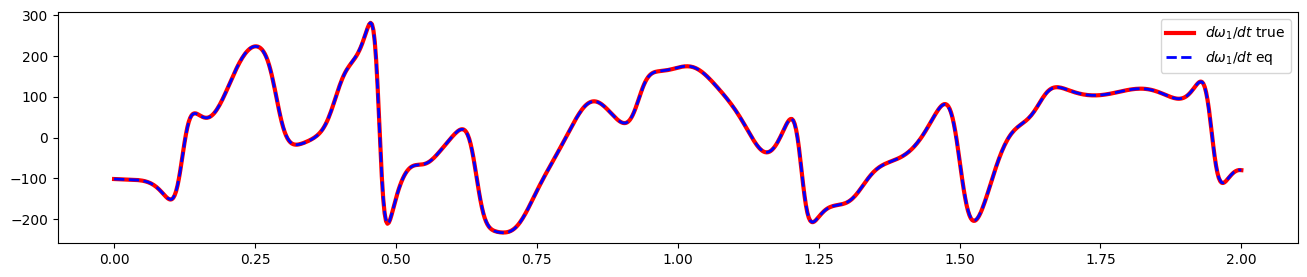

/tmp/ipykernel_398151/3843410545.py:36: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(t_m_all, dw2_true, 'k-', c='r', lw=3, label='$d\omega_2/dt$ true')


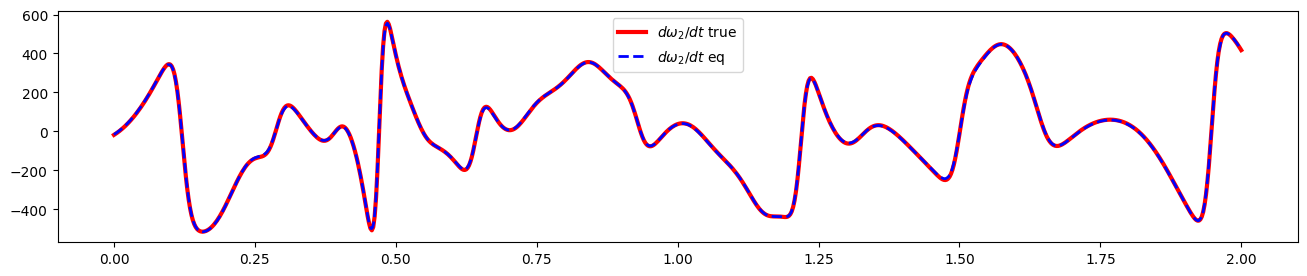

In [10]:
x1 = sim_measurement[:, 0]
x2 = sim_measurement[:, 1]
w1 = sim_measurement[:, 2]
w2 = sim_measurement[:, 3]

true_value_w1 = '(m2*L1*w1**2*sin(2*x1-2*x2) + 2*m2*L2*w2**2*sin(x1-x2) + 2*g*m2*cos(x2)*sin(x1-x2) + 2*g*m1*sin(x1))' + \
                '/ (-2*L1*(m2*sin(x1-x2)**2 + m1))'
true_value_w2 = '(m2*L2*w2**2*sin(2*x1-2*x2) + 2*(m1+m2)*L1*w1**2*sin(x1-x2) + 2*g*(m1+m2)*cos(x1)*sin(x1-x2))' + \
                '/ (2*L2*(m2*sin(x1-x2)**2 + m1))'

m1 = 35
m2 = 10
L1 = 9.1
L2 = 7
g = 981

dw1_true = eval(true_value_w1)
dw2_true = eval(true_value_w2)


x1 = torch.matmul(N_c, P[:, 0]).cpu().detach().numpy()
x2 = torch.matmul(N_c, P[:, 1]).cpu().detach().numpy()
w1 = torch.matmul(N_c, P[:, 2]).cpu().detach().numpy()
w2 = torch.matmul(N_c, P[:, 3]).cpu().detach().numpy()
dw1 = torch.matmul(N_dt, P[:, 2]).cpu().detach().numpy()
dw2 = torch.matmul(N_dt, P[:, 3]).cpu().detach().numpy()

plt.figure(figsize=(16,3))
plt.plot(t_m_all, dw1_true, 'k-', c='r', lw=3, label='$d\omega_1/dt$ true')
plt.plot(t_c[:-1], eval(function_dw1)[:-1], '--', c='b', lw=2, label='$d\omega_1/dt$ eq')

plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.plot(t_m_all, dw2_true, 'k-', c='r', lw=3, label='$d\omega_2/dt$ true')
plt.plot(t_c[:-1], eval(function_dw2)[:-1], '--', c='b', lw=2, label='$d\omega_2/dt$ eq')
plt.legend()
plt.show()

In [16]:
def predict_from_last_frame(function_dw1, function_dw2, training_data, num_predictions, dt):
    """
    Predict double pendulum motion starting from the last frame of training data.

    Parameters:
    - function_dw1: String, equation for angular acceleration of first pendulum (dω1/dt).
    - function_dw2: String, equation for angular acceleration of second pendulum (dω2/dt).
    - training_data: Numpy array of shape (N, 4), the training data [θ1, θ2, ω1, ω2].
    - num_predictions: Integer, number of frames to predict.
    - dt: Float, time step for integration.

    Returns:
    - predicted_results: Numpy array of shape (num_predictions, 4), predicted [θ1, θ2, ω1, ω2].
    """
    # Extract the last frame as initial condition
    θ1, θ2, ω1, ω2 = training_data[-1, :]  # Last frame of training data

    # Prepare storage for predictions
    predicted_results = np.zeros((num_predictions, 4))
    predicted_results[0, :] = [θ1, θ2, ω1, ω2]

    # Predict step by step using the provided equations
    for t in range(1, num_predictions):
        # Current state
        x1, x2, w1, w2 = predicted_results[t - 1, :]

        # Ensure x1, x2, w1, w2 are scalars
        x1 = x1.item() if isinstance(x1, (np.ndarray, np.generic)) else x1
        x2 = x2.item() if isinstance(x2, (np.ndarray, np.generic)) else x2
        w1 = w1.item() if isinstance(w1, (np.ndarray, np.generic)) else w1
        w2 = w2.item() if isinstance(w2, (np.ndarray, np.generic)) else w2

        # Evaluate angular accelerations using the equations
        dw1 = eval(function_dw1.replace('x1', 'x1').replace('x2', 'x2')
                                 .replace('w1', 'w1').replace('w2', 'w2'))
        dw2 = eval(function_dw2.replace('x1', 'x1').replace('x2', 'x2')
                                 .replace('w1', 'w1').replace('w2', 'w2'))

        # Update angular velocities and angles using Euler's method
        w1_new = w1 + dw1 * dt
        w2_new = w2 + dw2 * dt
        x1_new = x1 + w1_new * dt
        x2_new = x2 + w2_new * dt

        # Ensure x1_new and x2_new are scalars
        x1_new = x1_new.item() if isinstance(x1_new, (np.ndarray, np.generic)) else x1_new
        x2_new = x2_new.item() if isinstance(x2_new, (np.ndarray, np.generic)) else x2_new

        # Store predictions
        predicted_results[t, :] = [x1_new, x2_new, w1_new, w2_new]

    return predicted_results


training_data = np.array([[np.pi / 4, np.pi / 6, 0.0, 0.0]])  # 模拟训练数据
num_predictions = 10  # 预测 10 帧
dt = 0.01  # 时间步长

predicted_results = predict_from_last_frame(function_dw1, function_dw2, training_data, num_predictions, dt)

print(predicted_results)


ValueError: can only convert an array of size 1 to a Python scalar